In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pickle
from sklearn.model_selection import GroupKFold, KFold
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from keras.utils import plot_model


import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/mc90v-full/M2508_train_sensors.csv
/kaggle/input/mc90v-full/M2508_test_sensors.csv
/kaggle/input/mc90v-full/M2508_train_full.csv
/kaggle/input/mc90v-full/M2503_test_full.csv
/kaggle/input/mc90v-full/M2503_train_full.csv
/kaggle/input/mc90v-full/M0000_test_sensors.csv
/kaggle/input/mc90v-full/M2503_train_sensors.csv
/kaggle/input/mc90v-full/M2506_test_full.csv
/kaggle/input/mc90v-full/M0000_train_full.csv
/kaggle/input/mc90v-full/M0000_test_full.csv
/kaggle/input/mc90v-full/M2506_train_sensors.csv
/kaggle/input/mc90v-full/M2506_train_full.csv
/kaggle/input/mc90v-full/M2503_test_sensors.csv
/kaggle/input/mc90v-full/M0000_train_sensors.csv
/kaggle/input/mc90v-full/M2506_test_sensors.csv
/kaggle/input/mc90v-full/M2508_test_full.csv


### Read Data

In [2]:
m0000_train = pd.read_csv('/kaggle/input/mc90v-full/M0000_train_sensors.csv')
m0000_test = pd.read_csv('/kaggle/input/mc90v-full/M0000_test_sensors.csv')
m2503_train = pd.read_csv('/kaggle/input/mc90v-full/M2503_train_sensors.csv')
m2503_test = pd.read_csv('/kaggle/input/mc90v-full/M2503_test_sensors.csv')
m2506_train = pd.read_csv('/kaggle/input/mc90v-full/M2506_train_sensors.csv')
m2506_test = pd.read_csv('/kaggle/input/mc90v-full/M2506_test_sensors.csv')
m2508_train = pd.read_csv('/kaggle/input/mc90v-full/M2508_train_sensors.csv')
m2508_test = pd.read_csv('/kaggle/input/mc90v-full/M2508_test_sensors.csv')

### Preprocessing

In [3]:
def resample(df):
    df = df.interpolate().fillna(df.mean())
    df = df.groupby(df.index // 10).mean()
    return df

def prep(df):
    
    df = df.drop('Linear', axis =1)

    df['Id'] = df.groupby(['Class', 'RunId', 'Load','SeaTemp', 'WindSpeed']).ngroup() + 1
    df = df.groupby(['Class', 'RunId', 'Load','SeaTemp', 'WindSpeed']).apply(resample)

    return df

### Target Values

In [4]:
m0000_train['Class'] = 0
m2503_train['Class'] = 1
m2506_train['Class'] = 2
m2508_train['Class'] = 3

m0000_test['Class'] = 0
m2503_test['Class'] = 1
m2506_test['Class'] = 2
m2508_test['Class'] = 3

### Train & Test & Val

In [5]:
train = pd.concat([m0000_train, m2503_train, m2506_train, m2508_train])
test = pd.concat([m0000_test, m2503_test, m2506_test, m2508_test])

In [7]:
train_data = prep(train)
test_data = prep(test)

In [9]:
train_data['Id'] = train_data['Id'].astype(int)
train_data = train_data.drop(['RunId','Class'],axis=1).reset_index()
train_data['Class'] = train_data['Class'].astype(int)
train_data = pd.get_dummies(train_data.drop(['RunId','level_5'],axis=1))

In [11]:
def train_shuffle(data):
    
    grouped_data = data.groupby('Id', group_keys=False)
    id_list = grouped_data.apply(lambda x: x.iloc[0])['Id'].tolist()
    np.random.shuffle(id_list)
    
    shuffled_data = pd.concat([grouped_data.get_group(id_val) for id_val in id_list])
    
    return shuffled_data

In [12]:
train_data = train_shuffle(train_data)

In [13]:
def train_val_split(train_data):

    groups = [group for _, group in train_data.groupby('Id')]

    val_size = int(0.2 * len(train_data))
    val_data = pd.DataFrame()
    remaining_data = pd.DataFrame()

    accumulated_val_size = 0
    for group in groups:
        if accumulated_val_size + len(group) <= val_size:
            val_data = pd.concat([val_data, group])
            accumulated_val_size += len(group)
        else:
            remaining_data = pd.concat([remaining_data, group])

    train_data = remaining_data

    return train_data, val_data
    

In [14]:
train_data, val_data = train_val_split(train_data)

In [17]:
test_data['Id'] = test_data['Id'].astype(int)
test_data = test_data.drop(['RunId','Class'],axis=1).reset_index()
test_data['Class'] = test_data['Class'].astype(int)
test_data = pd.get_dummies(test_data.drop(['RunId','level_5'],axis=1))

In [19]:
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Validation size: {len(val_data)}")


Train size: 232677
Test size: 149897
Validation size: 58167


### Model

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

class LSTMClassifier():
    def __init__(self, train, test, validation, window_size=10, batch=32, epoch=100, verbose=1):
        tf.config.run_functions_eagerly(True)

        self.train = train
        self.test = test
        self.val = validation
        self.window_size = window_size
        self.num_classes = 4
        self.num_features = 52
        self.batch = batch
        self.epoch = epoch
        self.verbose = verbose
        self.scaler = StandardScaler()
        self.model = self.createLSTM()
        self.history = None

    def createLSTM(self):
        
        # Creates LSTM Model
        model = Sequential()
        model.add(LSTM(units=64, input_shape=(self.window_size, self.num_features), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=32))
        model.add(Dropout(0.2))
        model.add(Dense(units=self.num_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'], run_eagerly=True)
        return model

    def prepare_data(self, data):
        
        # Prepares the dataset with feature scaling, windowing and transformation
        X_sequences, y_sequences = [], []

        for run in np.unique(data['Id']):
            sub_data = data[data['Id'] == run].drop('Id',axis=1)
            X = self.scaler.transform(sub_data.drop('Class',axis=1))
            y = to_categorical(sub_data['Class'], self.num_classes)
            
            for i in range(len(X) - self.window_size + 1):
                X_sequences.append(X[i:i+self.window_size])
                y_sequences.append(y[i+self.window_size-1])

        return np.array(X_sequences), np.array(y_sequences)
    

    def fit(self):
        
        # Scaling
        self.scaler.fit(self.train.drop(['Id', 'Class'], axis=1))

        # Prepare Train and Validation data
        self.X_val, self.y_val = self.prepare_data(self.val)
        X_train, y_train = self.prepare_data(self.train)

        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

        # Training Model
        self.history = self.model.fit(
            X_train, y_train,
            batch_size=self.batch,
            epochs=self.epoch,
            verbose=self.verbose,
            validation_data=(self.X_val, self.y_val),
            callbacks=[early_stop]
        )

     
    def predict(self, data):
        
        X_test, actual_labels = self.prepare_data(data)
        
        prob = self.model.predict(X_test, verbose=1)
        y_pred = np.argmax(prob, axis=1)
        print(len(y_pred), len(actual_labels))

        return y_pred, actual_labels
    
    
    def plot_confusion_matrix(self, actual_labels_decoded, y_pred):
        plt.figure(figsize=(10,6))
        labels = ["M000","M2503","M2506","M2508"]
        cm = confusion_matrix(actual_labels_decoded, y_pred)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Values')
        plt.ylabel('Actual Values')
        plt.title('Confusion Matrix')
        plt.show()
        
    
    def print_classification_report(self, actual_labels_decoded, y_pred):
        print("Classification Report:")
        print(classification_report(actual_labels_decoded, y_pred))
        
        
    def print_accuracy_metrics(self, actual_labels_decoded, y_pred):
        accuracy = accuracy_score(actual_labels_decoded, y_pred)
        precision = precision_score(actual_labels_decoded, y_pred, average='weighted')
        recall = recall_score(actual_labels_decoded, y_pred, average='weighted')
        f1 = f1_score(actual_labels_decoded, y_pred, average='weighted')

        print(f'Test Accuracy: {accuracy}')
        print(f'Weighted Precision: {precision}')
        print(f'Weighted Recall: {recall}')
        print(f'Weighted F1 Score: {f1}')
        
        
    def plot_training_curves(self):
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    def evaluate(self, y_pred, actual_labels):
        actual_labels_decoded = np.argmax(actual_labels, axis=1)
        
        self.plot_confusion_matrix(actual_labels_decoded, y_pred)
        self.print_classification_report(actual_labels_decoded, y_pred)
        self.print_accuracy_metrics(actual_labels_decoded, y_pred)
        self.plot_training_curves()
    

### Model 1

#### window = 10  |  epoch = 30  |  batch = 64

#### Training

In [21]:
model1 = LSTMClassifier(train_data, test_data,val_data, window_size=10,epoch=100,batch=32,verbose=1)
model1.fit()

Epoch 1/100
6700/6700 [==============================] - 1017s 152ms/step - loss: 0.1197 - accuracy: 0.9496 - val_loss: 0.1625 - val_accuracy: 0.9370
Epoch 2/100
6700/6700 [==============================] - 943s 141ms/step - loss: 0.0669 - accuracy: 0.9709 - val_loss: 0.1331 - val_accuracy: 0.9472
Epoch 3/100
6700/6700 [==============================] - 985s 147ms/step - loss: 0.0590 - accuracy: 0.9743 - val_loss: 0.1388 - val_accuracy: 0.9482
Epoch 4/100
6700/6700 [==============================] - 925s 138ms/step - loss: 0.0549 - accuracy: 0.9761 - val_loss: 0.1057 - val_accuracy: 0.9544
Epoch 5/100
6700/6700 [==============================] - 959s 143ms/step - loss: 0.0518 - accuracy: 0.9775 - val_loss: 0.1120 - val_accuracy: 0.9515
Epoch 6/100
6700/6700 [==============================] - 889s 133ms/step - loss: 0.0500 - accuracy: 0.9783 - val_loss: 0.1103 - val_accuracy: 0.9598
Epoch 7/100
6700/6700 [==============================] - 929s 139ms/step - loss: 0.0485 - accuracy: 0.978

#### Predictions

In [22]:
y_pred1, actual_labels1 = model1.predict(test_data)

4323/4323 [==============================] - 194s 45ms/step
138323 138323


#### Evaluate Model

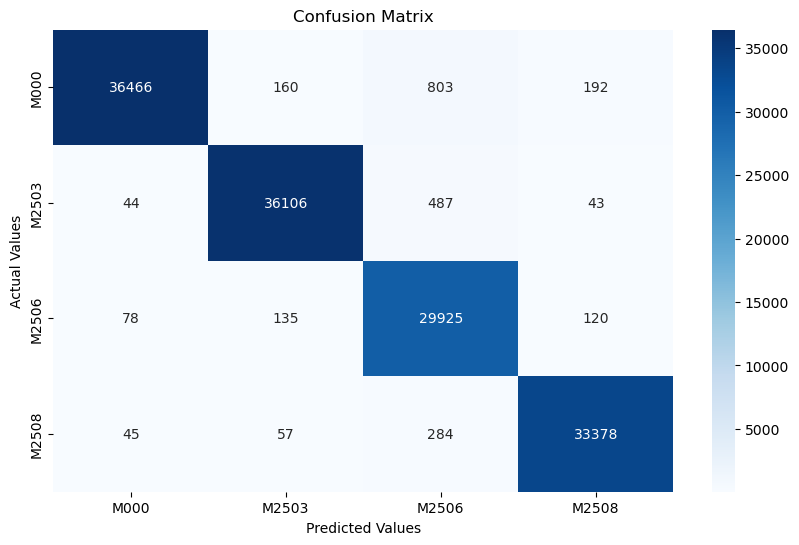

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     37621
           1       0.99      0.98      0.99     36680
           2       0.95      0.99      0.97     30258
           3       0.99      0.99      0.99     33764

    accuracy                           0.98    138323
   macro avg       0.98      0.98      0.98    138323
weighted avg       0.98      0.98      0.98    138323

Test Accuracy: 0.9823022924604007
Weighted Precision: 0.9827001938153408
Weighted Recall: 0.9823022924604007
Weighted F1 Score: 0.9823658385600094


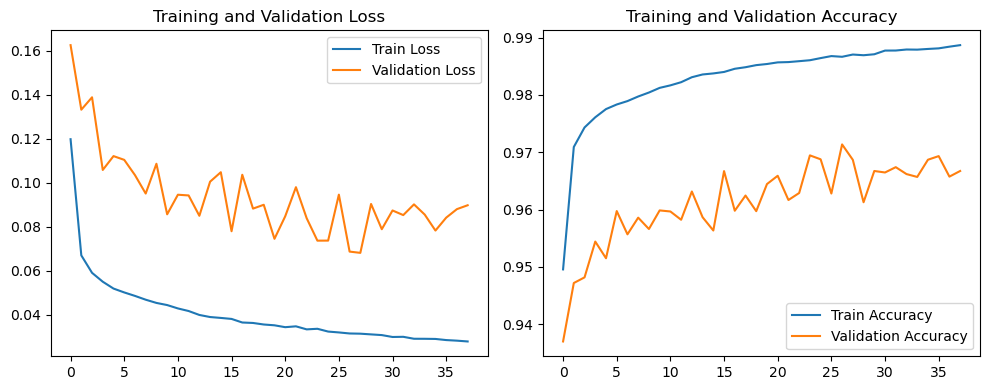

In [23]:
model1.evaluate(y_pred1, actual_labels1)